# Signaux III : projet detection de claviers

## **1. Prétraitement d’image**

**Objectif :** obtenir une image claire, binarisée et prête pour l’analyse des touches.

Étapes :

1. **Conversion en niveaux de gris** → `img_gray = rgb2gray(img)`
2. **Réduction de bruit** : filtre moyenneur ou médian.
3. **Amélioration du contraste** : histogramme égalisé.
4. **Seuillage automatique** (Otsu ou manuel) → `img_bin`.
5. **Morphologie** :

    - `ouverture` pour enlever les petits points.
    - `fermeture` pour combler les trous dans les touches.

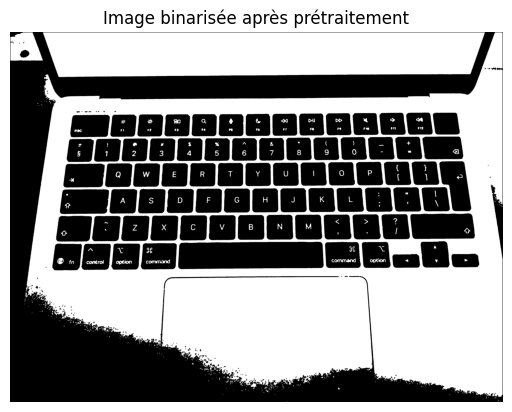

In [1]:
# Importer les dépendances
import os, sys
import matplotlib.pyplot as plt
from skimage import io

# Ajouter le répertoire parent au chemin Python pour que 'src' puisse être trouvé
sys.path.append(os.path.abspath('..'))

# Importer la fonction de prétraitement depuis preprocessing.py
from src.preprocessing import pretraiter_image

# Charger l’image d’entrée et appliquer le prétraitement pour obtenir une image binaire
chemin_image = '../data/img/INT-qwerty-1.jpg'
binaire = pretraiter_image(io.imread(chemin_image))

# Afficher l’image binaire résultante en niveaux de gris
plt.imshow(binaire, cmap='gray')
plt.title('Image binarisée après prétraitement')
plt.axis('off')
plt.show()

>À ce stade : on obtient une image “noir et blanc” où chaque touche est une forme isolée.

---

## **2. Détection des touches individuelles**

**Objectif :** repérer les touches et extraire leur géométrie.

- **Contours** : appliquer un algorithme de recherche de composantes connexes ou de contours (implémenté à la main si besoin).
- **Filtrage des régions** :

    - Supprimer les très petites ou très grandes (bruit, bords du clavier).
    - Garder les rectangles approximatifs.
- **Approximation rectangulaire** : calculer le rectangle englobant chaque touche.
- **Visualisation** : afficher les bounding boxes pour vérification.

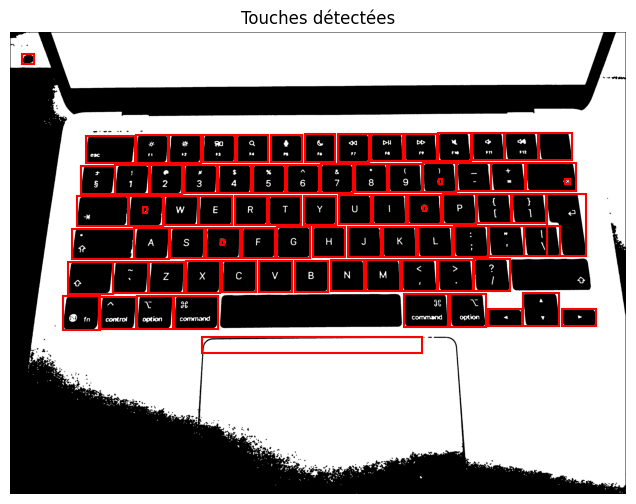

Nombre de touches détectées : 83


In [5]:
# 2ème cellule : Détection des rectangles des touches

from skimage import measure
import matplotlib.pyplot as plt
import numpy as np

# Inverser l'image binaire pour que les touches noires deviennent des objets
inverted = np.invert(binaire.astype(bool))

# Labeliser les composants connectés
labels = measure.label(inverted)
regions = measure.regionprops(labels)

# Filtrer les régions pour ne garder que les touches entières
min_area = 500
max_area = 100000
touch_boxes = []
for region in regions:
    minr, minc, maxr, maxc = region.bbox
    area = region.area
    if min_area <= area <= max_area:
        touch_boxes.append((minr, minc, maxr, maxc))

# Afficher les rectangles sur l'image binaire
plt.figure(figsize=(10,6))
plt.imshow(binaire, cmap='gray')
for bbox in touch_boxes:
    minr, minc, maxr, maxc = bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                         edgecolor='red', facecolor='none', linewidth=1.5)
    plt.gca().add_patch(rect)
plt.axis('off')
plt.title("Touches détectées")
plt.show()

print(f"Nombre de touches détectées : {len(touch_boxes)}")


---

## **3. Reconstruction de la grille**

**Objectif :** organiser les touches en lignes et colonnes.

- Trier les touches selon leur coordonnée `y` pour regrouper par ligne.
- Calculer la moyenne de `y` dans chaque groupe → lignes du clavier.
- Trier ensuite dans chaque ligne par coordonnée `x`.
- Représenter la structure comme une matrice de symboles (touches).
